In [1]:
from gan_synthesis.u_net_models.unet import UNet

In [6]:
model = UNet(anchor=32)

In [8]:
import torch
from gan_synthesis.preprocessing.transforms import read_cropped


image = read_cropped(t="contrast", idx=123, as_type="pt").unsqueeze(0)
model.eval()
with torch.no_grad():
    recon = model(image)

torch.Size([1, 128, 24, 24]) torch.Size([1, 128, 24, 24])
torch.Size([1, 64, 48, 48]) torch.Size([1, 64, 48, 48])


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from gan_synthesis.datasets.dataset import Dataset
from torch.utils.data import DataLoader
from gan_synthesis.u_net_models.unet import UNet
from tqdm import tqdm

# Instantiate data loaders
dataset = Dataset()
train_set, test_set = dataset.split(0.95)
train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
test_loader = DataLoader(test_set, batch_size=16, shuffle=True)

# Instantiate models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(anchor=32).to(device)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.005)
criterion = nn.CrossEntropyLoss(weight=dataset.weights.to(device))

# Before the loop
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
ce_losses = []

# final_z = torch.zeros(shape=)
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    running_kld_loss = 0.0
    running_ce_loss = 0.0
    running_dice_loss = 0.0

    # if epoch == 499:
    #     with torch.no_grad():
    #         recon, mu, logvar = model(seg_input)


    # if epoch % 10 == 0 and epoch != 0:
    #     with torch.no_grad:
    #         recon, mu, logvar = model

    for image, seg in tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False):
        correct, total = 0, 0
        contrast_input = image.to(torch.float32).to(device)
        seg_target = seg.squeeze(1).long().to(device)

        recon = model(contrast_input)
        # if epoch == 499:
        #     with torch.no_grad():
        # kld = kl_divergence(mu, logvar)
        # print(kld, kld.shape)

        ce_loss = criterion(recon, seg_target)
        loss = ce_loss

        pred = torch.argmax(recon, dim=1)
        correct += (pred == seg_target).sum().item()
        total += seg.numel()

        

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        running_ce_loss += ce_loss
        running_train_loss += loss.item()
    
    

    avg_train_loss = running_train_loss / len(train_loader)
    avg_kld_loss = running_kld_loss / len(train_loader)
    avg_ce_loss = running_ce_loss / len(train_loader)
    avg_dice_loss = running_dice_loss / len(train_loader)
    ce_losses.append(avg_ce_loss.item())
    train_losses.append(avg_train_loss)

    acc = correct / total
    train_accuracies.append(acc)

    # Validation
    model.eval()
    running_val_loss = 0.0
    correct, total = 0, 0

    with torch.no_grad():
        for image, seg in tqdm(test_loader, desc="Test", leave=False):
            contrast_input = image.to(device)
            seg_target = seg.squeeze(1).long().to(device)
            recon = model(contrast_input)
            ce_loss = criterion(recon, seg_target)
            loss = ce_loss
            running_val_loss += loss.item()

            pred = torch.argmax(recon, dim=1)
            correct += (pred == seg_target).sum().item()
            total += seg.numel()

    avg_val_loss = running_val_loss / len(test_loader)
    val_losses.append(avg_val_loss)

    acc = correct / total
    val_accuracies.append(acc)

    # print(f"[Epoch {epoch+1}] Train Loss: {avg_train_loss:.4f}, KLD Train Loss: {avg_kld_loss:.4f}, CE Train Loss: {avg_ce_loss:.4f}, Dice Train Loss: {avg_dice_loss:.4f}\
    #         \nVal Loss: {avg_val_loss:.4f}, Val Acc: {acc:.4f}")


Epoch 1:   0%|          | 0/22 [00:00<?, ?it/s]

In [8]:
PATH = ".model_weights.pth"
torch.save(model.state_dict(), PATH)

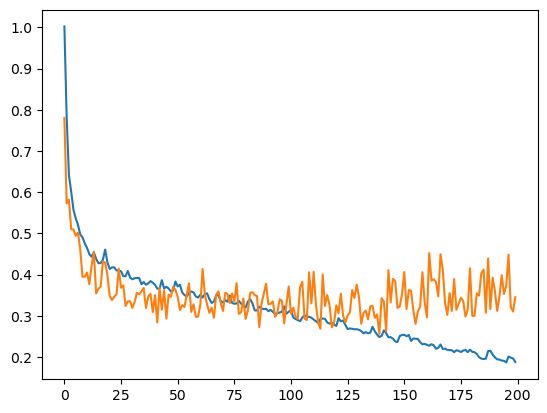

In [6]:
import matplotlib.pyplot as plt


plt.plot(ce_losses)
plt.plot(val_losses)
plt.show()

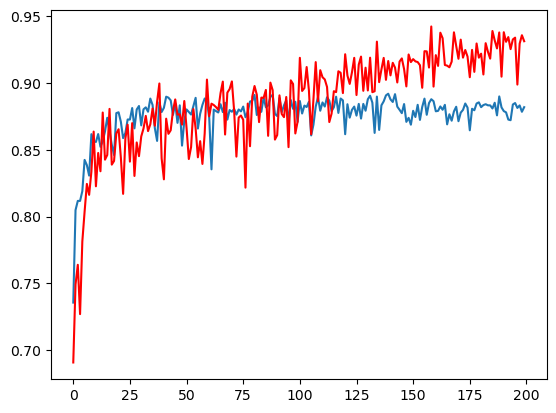

In [7]:
plt.plot(val_accuracies)
plt.plot(train_accuracies, 'r')
plt.show()

In [4]:
sum(param.numel() for param in model.parameters())

3421156